In [1]:
import pandas as pd
from scipy.stats import gamma
import numpy as np
import matplotlib.pyplot as plt

## Discretize the probability density functions of all edges

In [2]:
# Create range [0, T] with T = 4 to discretize our range of time when generating gamma distributions
x = np.linspace(0, 4, 4001)

# Create alpha and scale parameters for each edge
gammaParams = pd.DataFrame(
    columns=['1', '2', '3', '4', '5'],
    index=['1', '2', '3', '4', '5']
)
gammaParams.loc['1', '2'] = gammaParams.loc['2', '1'] = (1, 1)
gammaParams.loc['1', '3'] = gammaParams.loc['3', '1'] = (2, 2)
gammaParams.loc['1', '4'] = gammaParams.loc['4', '1'] = (2, 2)
gammaParams.loc['2', '3'] = gammaParams.loc['3', '2'] = (2, 2)
gammaParams.loc['2', '4'] = gammaParams.loc['4', '2'] = (1, 2)
gammaParams.loc['2', '5'] = gammaParams.loc['5', '2'] = (1, 1)
gammaParams.loc['3', '4'] = gammaParams.loc['4', '3'] = (2, 1)
gammaParams.loc['3', '5'] = gammaParams.loc['5', '3'] = (1, 2)
gammaParams.loc['4', '5'] = gammaParams.loc['5', '4'] = (2, 1)

# Create nodes
nodes = ['1', '2', '3', '4', '5']

# Create start and end node index
startNodeIndex = []
for node in nodes:
    startNodeIndex = np.append(startNodeIndex, np.full(shape=5, fill_value=node))

endNodeIndex = []
for node in nodes:
    endNodeIndex = np.append(endNodeIndex, nodes)

# Create gamma distribution 3D dataframe
gammaDistributions = pd.DataFrame(
    index=[startNodeIndex, endNodeIndex],
    columns=np.arange(0, 4001)
)
gammaDistributions.index.names = ['startNode', 'endNode']

# Generate probability distributions for each edge
for startNode, endNode in gammaDistributions.index:
        
    # Skip if edge does not exist
    if gammaParams.loc[startNode, endNode] is np.nan:
        continue

    # Find alpha and beta parameters for gamma distribution
    alpha, beta = gammaParams.loc[startNode, endNode]
    
    # Create probability distribution for edge by multiplying gamma distribution with time interval
    gammaDist = gamma.pdf(x, alpha, scale=beta) * 0.001
    # Set probability of edge taking 0 time to 0
    gammaDist[0] = 0
    gammaDistributions.loc[startNode, endNode] = gammaDist

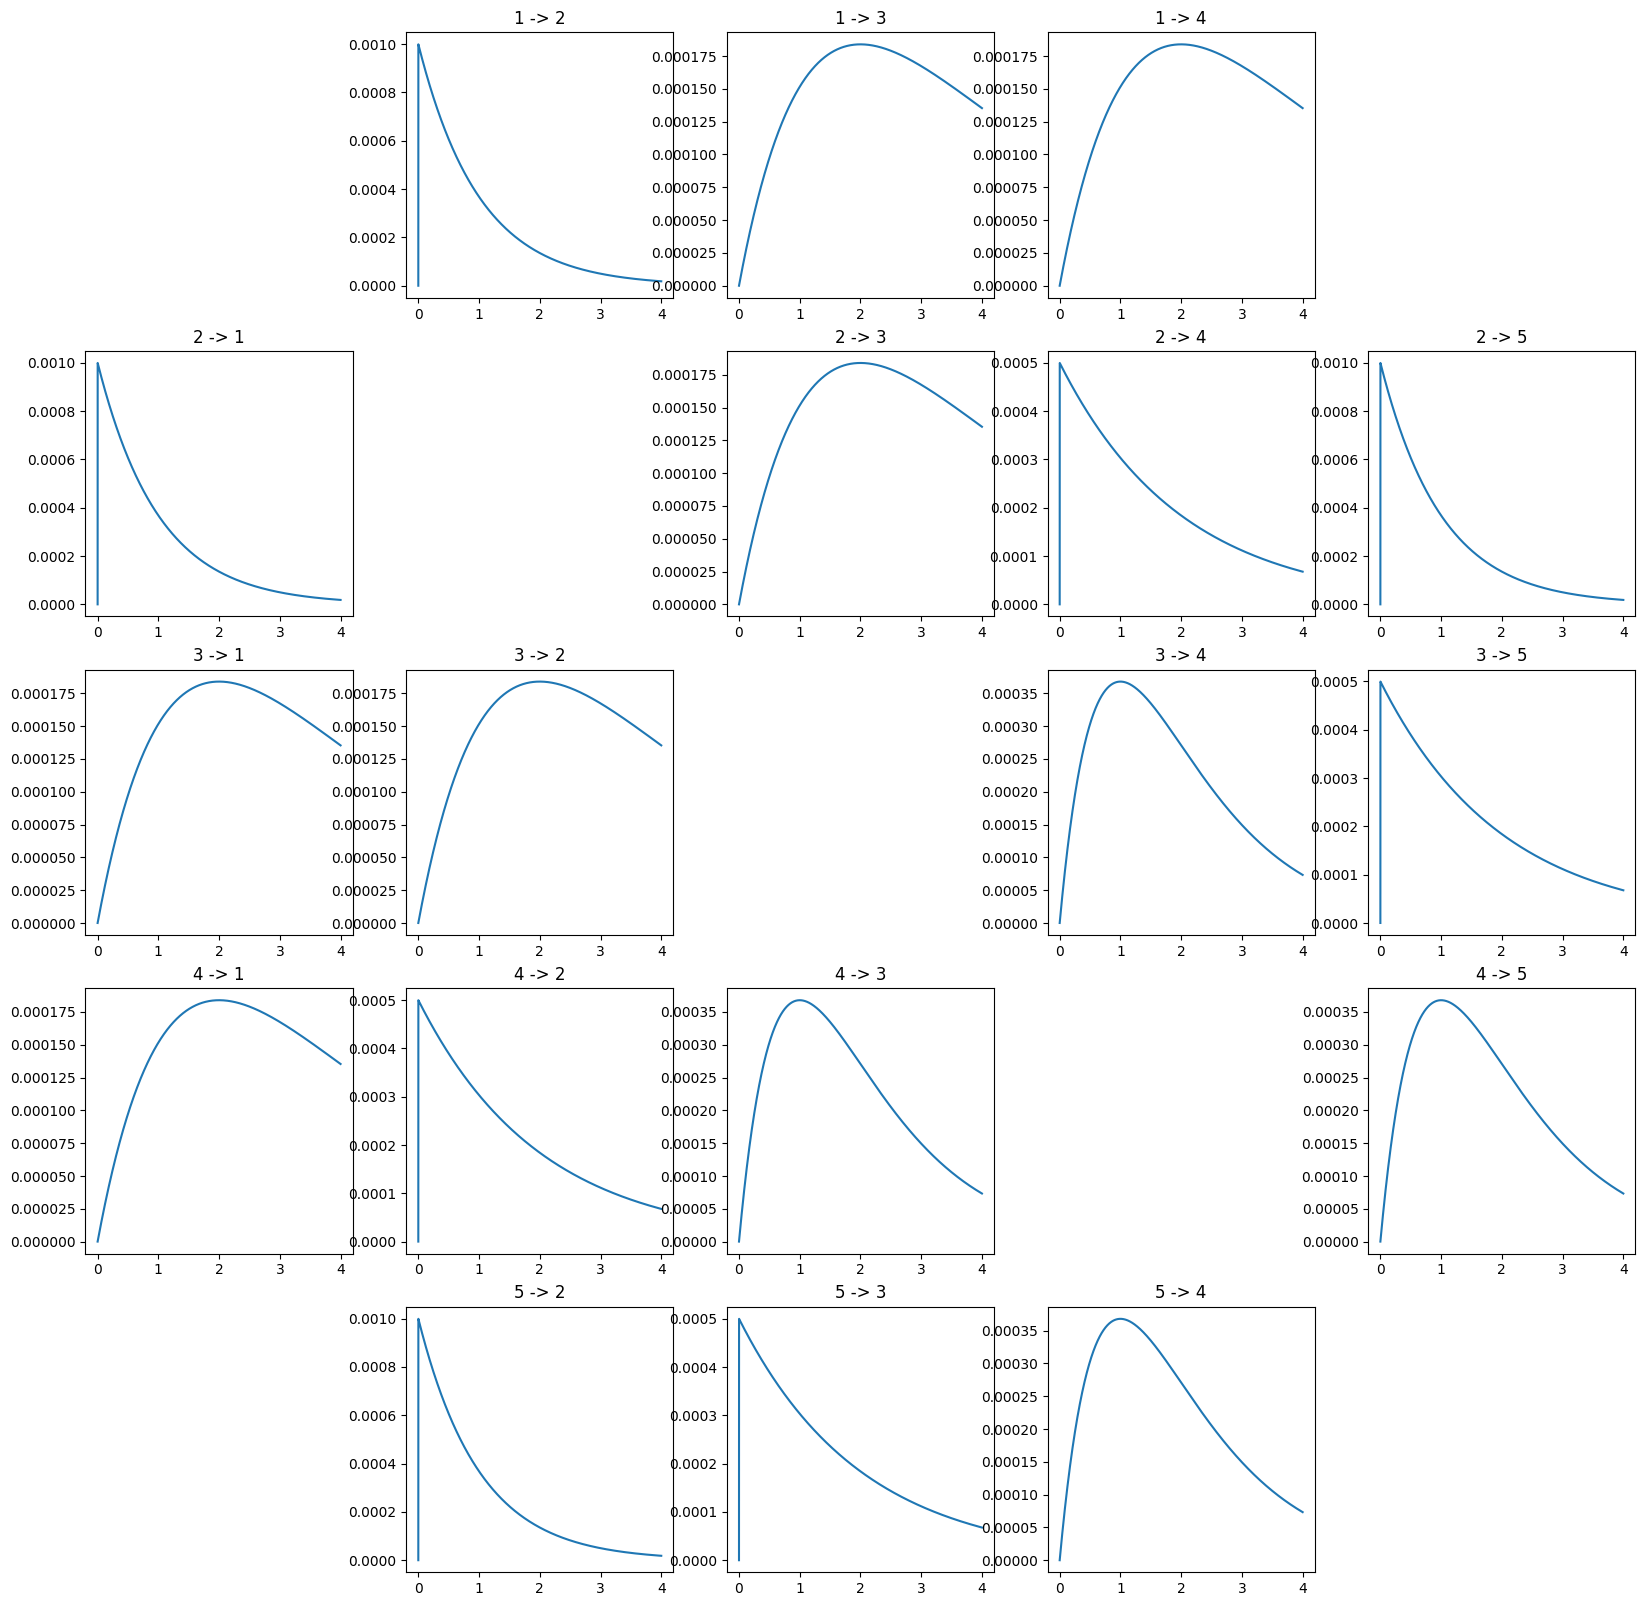

In [3]:
# Plot probability distributions for the heck of it
fig, axs = plt.subplots(5, 5, figsize=(20, 20))
for i, startNode in enumerate(nodes):
    for j, endNode in enumerate(nodes):
        if i == j or gammaParams.loc[startNode, endNode] is np.nan:
            axs[i, j].axis('off')
            continue
        axs[i, j].plot(x, gammaDistributions.loc[(startNode, endNode)])
        axs[i, j].set_title(f'{startNode} -> {endNode}')

In [4]:
for startNode, endNode in gammaDistributions.index:
    if gammaDistributions.loc[startNode, endNode] is np.nan:
        print(f'{startNode} -> {endNode} does not exist')
        continue
    else:
        print(f'{startNode} -> {endNode}: ',f'{gammaDistributions.loc[startNode, endNode].sum()}')

1 -> 1:  0
1 -> 2:  0.9811936007377352
1 -> 3:  0.5940617942789613
1 -> 4:  0.5940617942789613
1 -> 5:  0
2 -> 1:  0.9811936007377352
2 -> 2:  0
2 -> 3:  0.5940617942789613
2 -> 4:  0.8644485685980459
2 -> 5:  0.9811936007377352
3 -> 1:  0.5940617942789613
3 -> 2:  0.5940617942789613
3 -> 3:  0
3 -> 4:  0.908458348921869
3 -> 5:  0.8644485685980459
4 -> 1:  0.5940617942789613
4 -> 2:  0.8644485685980459
4 -> 3:  0.908458348921869
4 -> 4:  0
4 -> 5:  0.908458348921869
5 -> 1:  0
5 -> 2:  0.9811936007377352
5 -> 3:  0.8644485685980459
5 -> 4:  0.908458348921869
5 -> 5:  0


## Generate optimal probabilities and optimal policy tables

In [5]:
probabilities = pd.DataFrame(
    columns= np.arange(0, 4001),
    index=['1', '2', '3', '4', '5']
)

probabilities.loc['1', 0] = probabilities.loc['2', 0] = probabilities.loc['3', 0] = probabilities.loc['4', 0] = 0
probabilities.loc['5',] = 1

policy = pd.DataFrame(
    columns= np.arange(0, 4001),
    index=['1', '2', '3', '4', '5']
)

In [18]:
# Iterate through all time budgets
# for timeBudget in np.arange(0, 4001):
for timeBudget in np.arange(0, 4001):
    if timeBudget == 0:
        continue
    
    # Iterate through the four possible start nodes
    for startNode in ['1', '2', '3', '4']:
        
        # Initialize temporary probabilities for each end node
        tempProbabilities = pd.Series(data=np.zeros(5), index=['1', '2', '3', '4', '5'])
        
        # Iterate through all possible end nodes
        for endNode in ['1', '2', '3', '4', '5']:
            
            # Only iterate through start and end nodes that are adjacent
            if gammaDistributions.loc[startNode, endNode] is not np.nan:
                
                # Calculate optimal probability of reaching node 5 given the start node, end node, and time budget
                for timeUsed in np.arange(timeBudget, 0, -1):
                    temp = gammaDistributions.loc[startNode, endNode][timeUsed] * probabilities.loc[endNode, timeBudget - timeUsed]
                    # if startNode == '2':
                    #     print(f'Time budget: {timeBudget}')
                    #     print(f'Time used: {timeUsed}')
                    #     print(f'{startNode}-{endNode}')
                    #     print(f'Probability: {temp}')
                    tempProbabilities[endNode] += temp
                    # if startNode == '2':
                    #     print(f'{tempProbabilities}')
                    #     print('\n')
        
        # Store the optimal probability and optimal policy
        print(f'Start node: {startNode}')
        print(f'Time budget: {timeBudget}')
        print(f'{tempProbabilities}')
        print(f'{np.argmax(tempProbabilities)}')
        print('\n')
        probabilities.loc[startNode, timeBudget] = np.nanmax(tempProbabilities)

Start node: 1
Time budget: 1
1    0.0
2    0.0
3    0.0
4    0.0
5    0.0
dtype: float64
0


Start node: 2
Time budget: 1
1    0.000000
2    0.000000
3    0.000000
4    0.000000
5    0.000999
dtype: float64
4


Start node: 3
Time budget: 1
1    0.0000
2    0.0000
3    0.0000
4    0.0000
5    0.0005
dtype: float64
4


Start node: 4
Time budget: 1
1    0.000000e+00
2    0.000000e+00
3    0.000000e+00
4    0.000000e+00
5    9.990005e-07
dtype: float64
4


Start node: 1
Time budget: 2
1    0.000000e+00
2    9.980020e-07
3    1.248751e-10
4    2.496253e-13
5    0.000000e+00
dtype: float64
1


Start node: 2
Time budget: 2
1    0.000000e+00
2    0.000000e+00
3    1.248751e-10
4    4.992506e-10
5    1.997002e-03
dtype: float64
4


Start node: 3
Time budget: 2
1    0.000000e+00
2    2.496253e-10
3    0.000000e+00
4    9.980020e-13
5    9.992503e-04
dtype: float64
4


Start node: 4
Time budget: 2
1    0.000000e+00
2    4.992506e-07
3    4.992506e-10
4    0.000000e+00
5    2.995004e-06
dtype: flo

In [ ]:
# Iterate through the four possible start nodes
for startNode in ['1', '2', '3', '4']:

    # Iterate through all time budgets
    for timeBudget in np.arange(1, 4001):    
        
        # Initialize temporary probabilities for each end node
        nodeProbabilities = pd.Series(data=np.zeros(5), index=['1', '2', '3', '4', '5'])
            
        # Calculate optimal probability of reaching node 5 given the start node, end node, and time budget
        nodeProbabilities = 
            
    
    # Store the optimal probability and optimal policy
    probabilities.loc[startNode, timeBudget] = np.nanmax(tempProbabilities)

In [15]:
i=1
test1 = gammaDistributions.xs('1', level='startNode').iloc[:,1:i+1].copy()
test1 = test1.iloc[:, ::-1]
test2 = probabilities.iloc[:,0:i].copy()
display(test1)
display(test2)
# Perform element-wise multiplication
result = test1.values * test2.values

display(result)

row_sums = np.sum(result, axis=1)

display(row_sums)

i=2
test1 = gammaDistributions.xs('1', level='startNode').iloc[:,1:i+1].copy()
test1 = test1.iloc[:, ::-1]
test2 = probabilities.iloc[:,0:i].copy()
display(test1)
display(test2)
# Perform element-wise multiplication
result = test1.values * test2.values

display(result)

row_sums = np.sum(result, axis=1)

display(row_sums)

,1
endNode,
1,NaN
2,0.000999
3,0.0
4,0.0
5,NaN


,0
1,0
2,0
3,0
4,0
5,1


array([[nan],
       [0.0],
       [0.0],
       [0.0],
       [nan]], dtype=object)

array([nan, 0.0, 0.0, 0.0, nan], dtype=object)

,2,1
endNode,,
1,NaN,NaN
2,0.000998,0.000999
3,0.0,0.0
4,0.0,0.0
5,NaN,NaN


,0,1
1,0,NaN
2,0,NaN
3,0,NaN
4,0,NaN
5,1,1


array([[nan, nan],
       [0.0, nan],
       [0.0, nan],
       [0.0, nan],
       [nan, nan]], dtype=object)

array([nan, nan, nan, nan, nan], dtype=object)

## Simulation